In [13]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np

In [14]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


In [15]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

def show_images (images , labels):
    fig = plt.figure()
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i][0], cmap='gray')
        #print(images[i][0].shape)
        plt.title("Original Truth Label: {}".format(labels[i]))
        plt.yticks([])
        plt.xticks([])
    plt.show()

def show_image (image , label):

    plt.imshow(image, cmap='gray')
    #print(images[i][0].shape)
    #plt.title("Original Truth Label: {}".format(label[i]))
    plt.yticks([])
    plt.xticks([])
    plt.show()

#show_image(images[0] , labels[0])


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [16]:
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension, device=device)

In [17]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=100, hidden_dimension=128):
        super(Generator, self).__init__()

        self.n_dim = noise_dimension
        self.h_dim = hidden_dimension

        self.init_size = 7  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(self.n_dim, self.init_size * self.init_size * self.h_dim))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(self.h_dim),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim, self.h_dim // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(self.h_dim // 2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim // 2, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], self.h_dim, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
##%%
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            # Convolutional layer taking in 1 input channel (image), outputting 64 channels
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),  # 'same' padding in PyTorch is achieved with padding=2 for a 5x5 kernel
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout(0.5),

            # Second convolutional layer, 64 input channels, 128 output channels
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout(0.5),

            # Flatten the output for the dense layer
            nn.Flatten(),

            # Final dense layer to get to 1 output
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [21]:
# Training settings
num_epochs = 150  # Number of epochs to train for
batch_size = 64  # Batch size
noise_dimension = 100  # Dimension of the noise vector
data_loader = trainLoader
# Define optimizers for both generator and discriminator
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)

# Binary cross-entropy loss
criterion = nn.BCELoss()
# Placeholder for logging
losses = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)  # Move images to the same device as the model
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator with real images
        discriminator.zero_grad()
        real_loss = criterion(discriminator(images), real_labels)
        real_loss.backward()

        # Generate fake images
        noise = torch.randn(batch_size, noise_dimension, device=device)
        fake_images = generator(noise)

        # Train discriminator with fake images
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        fake_loss.backward()
        optimizer_discriminator.step()

        # Train generator
        generator.zero_grad()
        fake_labels.fill_(1.0)  # fake labels are real for generator cost
        gen_loss = criterion(discriminator(fake_images), fake_labels)
        gen_loss.backward()
        optimizer_generator.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], D_loss: {real_loss.item() + fake_loss.item()}, G_loss: {gen_loss.item()}")


Epoch [1/150], Step [100/938], D_loss: 1.237036406993866, G_loss: 0.8954127430915833
Epoch [1/150], Step [200/938], D_loss: 1.218465507030487, G_loss: 0.9201668500900269
Epoch [1/150], Step [300/938], D_loss: 1.3469383716583252, G_loss: 0.8958150148391724
Epoch [1/150], Step [400/938], D_loss: 1.3067229986190796, G_loss: 1.0039938688278198
Epoch [1/150], Step [500/938], D_loss: 1.2570979595184326, G_loss: 0.8572834730148315
Epoch [1/150], Step [600/938], D_loss: 1.2602776885032654, G_loss: 0.7993221282958984
Epoch [1/150], Step [700/938], D_loss: 1.1801327466964722, G_loss: 0.8144290447235107
Epoch [1/150], Step [800/938], D_loss: 1.2664692997932434, G_loss: 0.9187429547309875
Epoch [1/150], Step [900/938], D_loss: 1.1920481324195862, G_loss: 0.929832935333252
Epoch [2/150], Step [100/938], D_loss: 1.3019601106643677, G_loss: 0.9738048315048218
Epoch [2/150], Step [200/938], D_loss: 1.23206228017807, G_loss: 0.9552428722381592
Epoch [2/150], Step [300/938], D_loss: 1.315919280052185, G

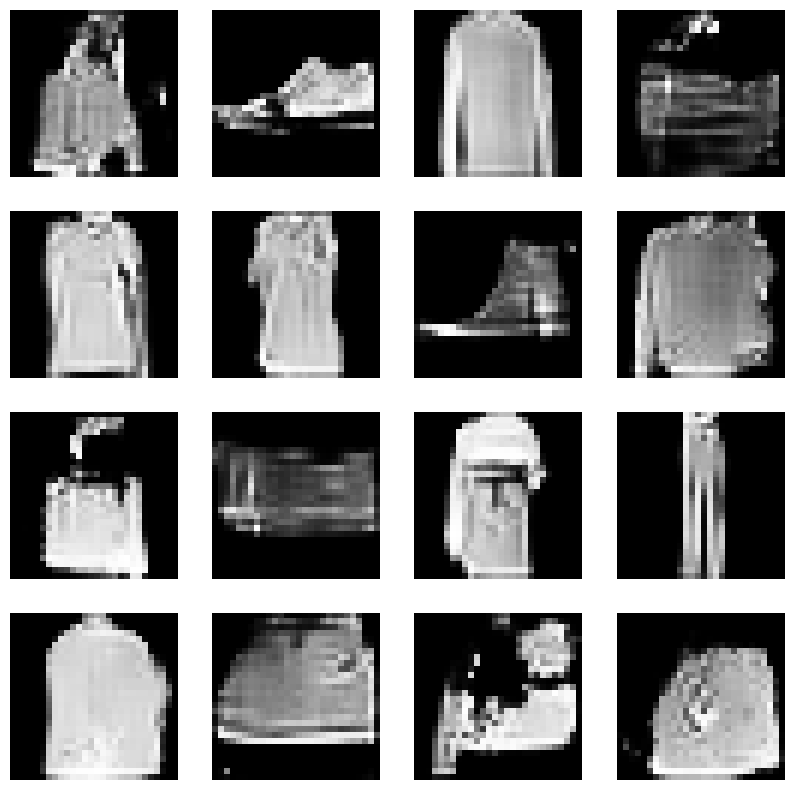

In [20]:
def plot_fake_images(generator, noise_dimension, device):
    noise = torch.randn(16, noise_dimension, device=device)
    with torch.no_grad():
        fake_images = generator(noise).reshape(-1, 1, 28, 28)
        fake_images = fake_images.cpu().detach().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = fake_images[i].transpose(1, 2, 0)
        img = ((img - img.min()) * (1 / (img.max() - img.min()) * 255)).astype(np.uint8)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

# Call the function to plot the fake images
plot_fake_images(generator, noise_dimension, device)


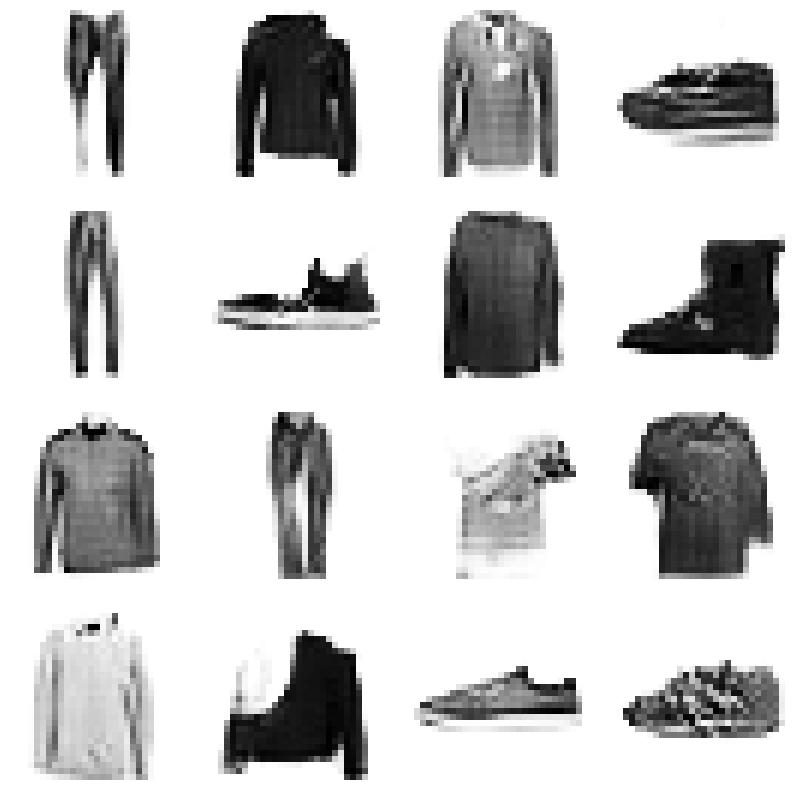

In [26]:
def plot_fake_images(generator, noise_dimension, device):
    noise = torch.randn(16, noise_dimension, device=device)
    with torch.no_grad():
        fake_images = generator(noise).reshape(-1, 1, 28, 28)
        fake_images = fake_images.cpu().detach().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = fake_images[i].transpose(1, 2, 0)
        img = ((img - img.min()) * (1 / (img.max() - img.min()) * 255)).astype(np.uint8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
    plt.show()

# Call the function to plot the fake images
plot_fake_images(generator, noise_dimension, device)